### Titanic Kaggle competition

#### Data Management

In [1]:
# import useful libraries
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif
from IPython.core.pylabtools import figsize
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
import re

%matplotlib inline
warnings.simplefilter('ignore')

sns.set(style = "darkgrid", palette = "muted")
pd.set_option("display.mpl_style", "default")
plt.rcParams['figure.figsize'] = 12, 6
np.random.seed(0)

In [2]:
def process_data(root):
    """
    Conveniance function:
        import and clean titanic data
    """
    data = pd.read_csv(root)
    titanic = data.copy()
    
    # thes variable can't help us predict the survived and there is too many nan for Cabin
    titanic = titanic.drop(["Cabin", "Ticket"], axis = 1)
    #del titanic["Cabin"], titanic["Ticket"]
    
    titanic.loc[titanic["Sex"] == "male", "Sex"] = 0
    titanic.loc[titanic["Sex"] == "female", "Sex"] = 1
    titanic.loc[titanic["Embarked"] == "S", "Embarked"] = 0
    titanic.loc[titanic["Embarked"] == "C", "Embarked"] = 1
    titanic.loc[titanic["Embarked"] == "Q", "Embarked"] = 2
    
    #Notice if no NAN nothing will be done
    titanic["Age"] = titanic["Age"].fillna(titanic["Age"].median())
    titanic["Embarked"] = titanic["Embarked"].fillna(0)
    titanic["Fare"] = titanic["Fare"].fillna(titanic["Fare"].median())
    
    return titanic


def get_title(name):
    """
    Convenience function : 
        Get title, Mr. Mrs, Master form the name 
    """
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

In [3]:
root_train = r"/Users/Kenneth-Aristide/anaconda3/bin/python_prog/ML/data/train_titanic.csv"
root_test = r"/Users/Kenneth-Aristide/anaconda3/bin/python_prog/ML/data/test_titanic.csv"

titanic = process_data(root_train)
titanic_test = process_data(root_test)

### Simple machine learning predictive model with sklearn library

In [4]:
# On to Modelling, we will start with a simple linear regression with sklearn

from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import KFold


predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]

# Initialise the Linear regression class
LR = LinearRegression()

# Generate Cross Validation folds returning row indices corresponding to train and test 
# We set random_state  to ensure we get the same split anytime we run this

kf = KFold(titanic.shape[0], n_folds = 3, random_state = 1)

predictions = []

for train, test in kf:
    
    train_predictors = titanic[predictors].iloc[train, :] # take all columns
    train_target = titanic["Survived"].iloc[train] # just one
    
    # Training the algorithm LR
    LR.fit(train_predictors, train_target)
    
    # make predictions on the test fold
    test_predictions = LR.predict(titanic[predictors].iloc[test, :])
    predictions.append(test_predictions)
    

# Let's evaluate the error, the error metric here is the percentage of correct prediction
predictions = np.concatenate(predictions, axis = 0)
predictions[predictions > .5] = 1
predictions[predictions <= .5] = 0

accuracy = np.sum(predictions[predictions == titanic["Survived"]]) / len(predictions)
print("linear regression score : {}".format(accuracy))

linear regression score : 0.7833894500561167


In [5]:
# Let's try with Logistic Regression to output value between 0 and 1
from sklearn.linear_model import LogisticRegression
from sklearn import cross_validation

#Initialize the algorithm
LR = LogisticRegression(random_state = 1)

# compute the score for all cross-validation folds, much simpler than before
scores = cross_validation.cross_val_score(LR, titanic[predictors], titanic["Survived"], cv = 3)
print("Logistic Regression score :  {}".format(scores.mean()))

Logistic Regression score :  0.7878787878787877


In [6]:
# Train the a logistic regression algorithm and make a submission file with his result

LR = LogisticRegression()
LR.fit(titanic[predictors], titanic["Survived"])

# Make predictions using the test set
_predictions = LR.predict(titanic_test[predictors])

# Generate a first submission file
submission = pd.DataFrame({
        'PassengerID': titanic_test["PassengerId"],
        'Survived': _predictions
    })

### Features engeeniring
Let's try to improve our score now by : 
1. trying to figure out what can be the best $features$ for the algorithm
2. Use a better machine learning algorthim
3. combine multiple machine learning algorithm : $Ensembling$

### Random Forest
<i>Random Forest</i> can pick $nonlinear$ tendencies in the data
With random forest, we build hundreds of trees with slightly randomized input data, and slightly randomized split points. Each trees in a random forest gets a random subset of the overall training data. Each split point in each tree is performed on a random subset of the potential columns to split on.
By avereging the predictions of all the trees, we get a strong overall prediction and minimize overfitting

In [7]:
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier

predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]

# Initialize our algorithm with default parameter 
# n_estimators is the number of tree we want to make
# min_samples_split is the minimum number of rows we need to make a split
# min_samples_leaf is the minimum number of sample we can have at the place where 
# a tree branch end (the bottom point of the tree)

RFC = RandomForestClassifier(random_state = 1, n_estimators = 10, min_samples_split = 2, min_samples_leaf = 1)

scores = cross_validation.cross_val_score(RFC, titanic[predictors], titanic["Survived"], cv = 3)
print("Random Forest Classifier score {}".format(scores.mean()))

Random Forest Classifier score 0.8013468013468014


### Random Forest parameter tunning
1. The first and easier way to improve the accuracy is to increase the number of tree we're using.
2. Training more tree will take more time, but because we of the fact that we are averaging the many prediction made on different subsets of the data, having more tree will increase accuracy.
3. Increase <b>min_samples_split</b> and <b>min_smples_leaf</b> can reduce overfitting.
We will end up with a model that less overfit, and that can generalize better and it will actually perform better on unseen data but worse on seen data

In [8]:
_RFC = RandomForestClassifier(random_state = 1, n_estimators = 50, min_samples_split = 4, min_samples_leaf = 2)

scores = cross_validation.cross_val_score(_RFC, titanic[predictors], titanic["Survived"], cv = 3)
print("Random Forest Classifier with more tree score {}".format(scores.mean()))

Random Forest Classifier with more tree score 0.8204264870931537


### Generating new features (predictors)

In [9]:
titanic["FamilySize"] = titanic["SibSp"] + titanic["Parch"]
titanic["NameLenght"] = titanic["Name"].apply(lambda x : len(x))

In [10]:
# Get all the titles and print how often each occurs
titles = titanic["Name"].apply(get_title)
print(pd.value_counts(titles))

# Map each title to an integer.  Some titles are very rare, and are compressed into the same codes as other titles.
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 7, "Mlle": 8, 
                 "Mme": 8, "Don": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, "Sir": 9, "Capt": 7, "Ms": 2}
for k,v in title_mapping.items():
    titles[titles == k] = v


# Verify that we converted everything well
print(pd.value_counts(titles))

# Add in the title column.
titanic["Title"] = titles
    

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Mlle          2
Major         2
Capt          1
Don           1
Countess      1
Jonkheer      1
Ms            1
Lady          1
Mme           1
Sir           1
Name: Name, dtype: int64
1     517
2     183
3     125
4      40
5       7
6       6
7       5
10      3
8       3
9       2
Name: Name, dtype: int64


### Finding the best features
Features engineering is the most important part of any machine learning task, and there is a lot of more feature we could calculate. But we also need a way to figure out which feature is the best.

One way to do this is to use $univariate$ $feature$ $selection$, this essentially goes coulumn by column and figure out which column correlate most closely with what we are trying to predict.

$SelectKBest$ from sklearn elect the best feature from data, and allows to specify how many it select.

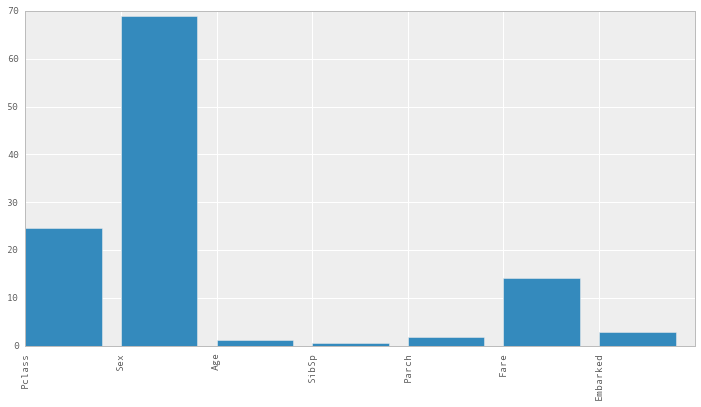

0.81705948372615034

In [12]:
# perform feature selection
selector = SelectKBest(f_classif, k = 5)
selector.fit(titanic[predictors], titanic["Survived"])

# Get the raw p-values for each feature, and transform from p-values into scores
scores = -np.log10(selector.pvalues_)

plt.bar(np.arange(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.show();

# pick the only the best predictors
predictors = ["Pclass", "Sex", "Fare", "Title"]

_RFC_ = RandomForestClassifier(random_state = 1, n_estimators = 50, min_samples_split = 8, min_samples_leaf = 4)
_scores = cross_validation.cross_val_score(_RFC_, titanic[predictors], titanic["Survived"], cv = 3)
_scores.mean()

### Gradient Boosting
Another method that builds on a decision trees is $Gradient$ $Boosting$ $Classifier$ : 
    $Boosting$ involves training a ecision trees one after another, and feeding the $errors$ form trees into the next tree.
So each tree is building on all the other trees that cames before it. Tjis can lead to overfitting if we build to many trees, though. 

Another way to limit overfitting is to limit the depth to which each tree in the gradient boosting procees can be build. We'll limit the tree depth to 3 to avoid overfitting.

We'll try boosting instead of our random forest approach and see if we can improve our accuracy.

### Ensembling
One thing we can do to improve the accuracy of our predictions is to ensemble different classifiers. $Ensembling$ means that we generate predictions using information from a set of classifiers, instead of just one. In practice, this means that we average their predictions.

Generally, the more diverse the models we ensemble, the higher our accuracy will be. Diversity means that the models generate their results from different columns, or use a very different method to generate predictions. Ensembling a random forest classifier with a decision tree probably won't work extremely well, because they are very similar. On the other hand, ensembling a linear regression with a random forest can work very well.

One caveat with ensembling is that the classifiers we use have to be about the same in terms of accuracy. Ensembling one classifier that is much worse than another probably will make the final result worse.

In this case, we'll ensemble logistic regression trained on the most linear predictors (the ones that have a linear ordering, and some correlation to Survived), and a gradient boosted tree trained on all of the predictors.

we'll average the raw probabilities (from 0 to 1) that we get from our classifiers, and then assume that anything above .5 maps to one, and anything below or equal to .5 maps to 0.

In [13]:
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np

# The algorithms we want to ensemble.
# We're using the more linear predictors for the 
#logistic regression, and everything with the gradient boosting classifier.

algorithms = [
    [GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3), 
     ["Pclass", "Sex", "Age", "Fare", "Embarked", "FamilySize", "Title", "FamilyId"]],
    [LogisticRegression(random_state=1), ["Pclass", "Sex", "Fare", "FamilySize", "Title", "Age", "Embarked"]]
]

# Initialize the cross validation folds
kf = KFold(titanic.shape[0], n_folds=3, random_state=1)

predictions = []
for train, test in kf:
    train_target = titanic["Survived"].iloc[train]
    full_test_predictions = []
    # Make predictions for each algorithm on each fold
    for alg, predictors in algorithms:
        # Fit the algorithm on the training data.
        alg.fit(titanic[predictors].iloc[train,:], train_target)
        # Select and predict on the test fold.  
        # The .astype(float) is necessary to convert the dataframe to all floats and avoid an sklearn error.
        test_predictions = alg.predict_proba(titanic[predictors].iloc[test,:].astype(float))[:,1]
        full_test_predictions.append(test_predictions)
    # Use a simple ensembling scheme -- just average the predictions to get the final classification.
    test_predictions = (full_test_predictions[0] + full_test_predictions[1]) / 2
    # Any value over .5 is assumed to be a 1 prediction, and below .5 is a 0 prediction.
    test_predictions[test_predictions <= .5] = 0
    test_predictions[test_predictions > .5] = 1
    predictions.append(test_predictions)

# Put all the predictions together into one array.
predictions = np.concatenate(predictions, axis=0)

# Compute accuracy by comparing to the training data.
accuracy = sum(predictions[predictions == titanic["Survived"]]) / len(predictions)
print(accuracy)

0.819304152637


In [14]:
# First, we'll add titles to the test set.
titles = titanic_test["Name"].apply(get_title)
# We're adding the Dona title to the mapping, because it's in the test set, but not the training set
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3,
                 "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 7, "Mlle": 8, "Mme": 8, 
                 "Don": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, "Sir": 9, "Capt": 7, "Ms": 2, "Dona": 10}

for k,v in title_mapping.items():
    titles[titles == k] = v
titanic_test["Title"] = titles
# Check the counts of each unique title.
print(pd.value_counts(titanic_test["Title"]))

# Now, we add the family size column.
titanic_test["FamilySize"] = titanic_test["SibSp"] + titanic_test["Parch"]

# Now we can add family ids.
# We'll use the same ids that we did earlier.
#print(family_id_mapping)

family_ids = titanic_test.apply(get_family_id, axis=1)
family_ids[titanic_test["FamilySize"] < 3] = -1
titanic_test["FamilyId"] = family_ids
titanic_test["NameLength"] = titanic_test["Name"].apply(lambda x: len(x))

1     240
2      79
3      72
4      21
7       2
6       2
10      1
5       1
Name: Title, dtype: int64


In [15]:
predictors = ["Pclass", "Sex", "Age", "Fare", "Embarked", "FamilySize", "Title", "FamilyId"]

algorithms = [
    [GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3), predictors],
    [LogisticRegression(random_state=1), ["Pclass", "Sex", "Fare", "FamilySize", "Title", "Age", "Embarked"]]
]

full_predictions = []
for alg, predictors in algorithms:
    # Fit the algorithm using the full training data.
    alg.fit(titanic[predictors], titanic["Survived"])
    # Predict using the test dataset.  We have to convert all the columns to floats to avoid an error.
    predictions = alg.predict_proba(titanic_test[predictors].astype(float))[:,1]
    full_predictions.append(predictions)

# The gradient boosting classifier generates better predictions, so we weight it higher.
predictions = (full_predictions[0] * 3 + full_predictions[1]) / 4

Hint : 
    1. Try the random forest classifier in the ensemble
    2. A support Vector machine might work well with this data
    3. We could try a Neural Network
    4. Boosting with different base classifier might work better